# Histogram-based Gradient Boosting Classification Tree

Libraries and data.

In [14]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn import metrics

# Data
X_train_df = pd.read_csv('../data/gold/X_train_df.csv', index_col='respondent_id') # training set features

training_set_labels_df = pd.read_csv('../data/raw/training_set_labels.csv', index_col='respondent_id') # training set labels

X_test_df = pd.read_csv('../data/gold/X_test_df.csv', index_col='respondent_id') # test set features

submission_format_df = pd.read_csv('../data/raw/submission_format.csv', index_col='respondent_id') # submission format

Data split.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df, training_set_labels_df, test_size=0.2, random_state=42, stratify=training_set_labels_df)

Cross-validation.

In [16]:
# Set up the MultiOutputClassifier with Random Forest Regressor
multi_output_clf = MultiOutputClassifier(HistGradientBoostingClassifier(random_state=42))

In [17]:
# # Let's do GridSearchCV
# # parameters grid
# param_grid = {
#     "estimator__learning_rate" : [0.05, 0.1, 0.2, 0.3],
#     "estimator__max_iter" : [100, 200, 300],
#     "estimator__max_leaf_nodes" : [31, 63, 127],
#     "estimator__max_depth" : [None, 5, 10, 20, 30],
#     "estimator__min_samples_leaf" : [20, 50, 100],
# }

In [18]:
# # Initialize Grid Search
# grid_search = GridSearchCV(estimator=multi_output_clf, param_grid=param_grid,
#                            cv=5, n_jobs=-1, verbose=2)

# # Fit the Grid Search model
# grid_search.fit(X_train, y_train)

# # Print the best parameters and best score
# print("Best Parameters from Grid Search:", grid_search.best_params_)
# print("Best Score from Grid Search:", grid_search.best_score_)

# # Evaluate on the test set
# y_pred_grid = grid_search.predict(X_test)
# mse_grid = mean_squared_error(y_test, y_pred_grid)
# acc_grid = accuracy_score(y_test, y_pred_grid)
# print(f"Mean Squared Error (Grid Search): {mse_grid}")
# print(f"Accuracy (Grid Search): {acc_grid}")

Best hyperparameters.

In [19]:
estimators = MultiOutputClassifier(
    estimator = HistGradientBoostingClassifier(
        learning_rate = 0.05, 
        max_depth = 5,
        max_iter = 200,
        max_leaf_nodes = 31,
        min_samples_leaf = 100
    )
)
# estimators = MultiOutputClassifier(estimator=HistGradientBoostingClassifier())

The model is trained to study performance.

In [20]:
estimators.fit(X_train, y_train)

MultiOutputClassifier(estimator=HistGradientBoostingClassifier(learning_rate=0.05,
                                                               max_depth=5,
                                                               max_iter=200,
                                                               min_samples_leaf=100))

Predictions.

In [21]:
preds = estimators.predict_proba(X_test)
preds

[array([[0.98780247, 0.01219753],
        [0.58307271, 0.41692729],
        [0.95391758, 0.04608242],
        ...,
        [0.97239808, 0.02760192],
        [0.61941294, 0.38058706],
        [0.71149275, 0.28850725]]),
 array([[0.68951128, 0.31048872],
        [0.20630294, 0.79369706],
        [0.88390435, 0.11609565],
        ...,
        [0.90799811, 0.09200189],
        [0.36607271, 0.63392729],
        [0.46028845, 0.53971155]])]

A dataframe is created with the predictions.

In [22]:
y_preds = pd.DataFrame(
    {
        'h1n1_vaccine': preds[0][:,1],
        'seasonal_vaccine':preds[1][:,1],
    },
    index=y_test.index
)
print('y_preds.shape:', y_preds.shape)
y_preds.head()

y_preds.shape: (5342, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
22317,0.012198,0.310489
1215,0.416927,0.793697
10540,0.046082,0.116096
7407,0.209940,0.260612
14697,0.112511,0.211001


ROC curve to evaluate the model.

In [23]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0,1], [0,1], color='red', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

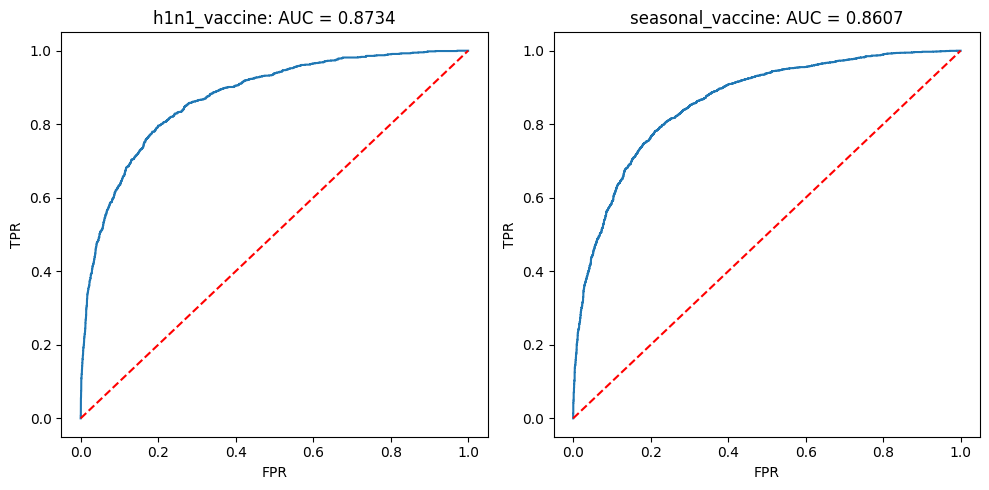

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

plot_roc(
    y_test['h1n1_vaccine'],
    y_preds['h1n1_vaccine'],
    'h1n1_vaccine',
    ax=ax[0])

plot_roc(
    y_test['seasonal_vaccine'],
    y_preds['seasonal_vaccine'],
    'seasonal_vaccine',
    ax=ax[1])

fig.tight_layout()

// EXPLICAR LOS RESULTADOS DE LA ROC CURVE

Confusion matrix.

In [ ]:
# h1n1_vaccine
cm = metrics.confusion_matrix(y_test['h1n1_vaccine'], y_preds['h1n1_vaccine'])
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=estimators.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Print the classification report
print(metrics.classification_report(y_test['h1n1_vaccine'], y_preds['h1n1_vaccine']))

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [ ]:

cm = metrics.confusion_matrix(y_test['seasonal_vaccine'], y_preds['seasonal_vaccine'])
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=estimators.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Print the classification report
print(metrics.classification_report(y_test['seasonal_vaccine'], y_preds['seasonal_vaccine']))

The model is trained for the competition.

In [40]:
estimators.fit(X_train_df, training_set_labels_df)
preds = estimators.predict_proba(X_test_df)
preds

[array([[0.83206424, 0.16793576],
        [0.97169781, 0.02830219],
        [0.83511655, 0.16488345],
        ...,
        [0.74846234, 0.25153766],
        [0.98273254, 0.01726746],
        [0.35498553, 0.64501447]]),
 array([[0.81142242, 0.18857758],
        [0.97160285, 0.02839715],
        [0.30052974, 0.69947026],
        ...,
        [0.80248471, 0.19751529],
        [0.69098709, 0.30901291],
        [0.30220622, 0.69779378]])]

A dataframe is created with the predictions.

In [41]:
y_preds = pd.DataFrame(
    {
        'h1n1_vaccine': preds[0][:,1],
        'seasonal_vaccine':preds[1][:,1],
    },
    index=X_test_df.index
)
print('y_preds.shape:', y_preds.shape)
y_preds.head()

y_preds.shape: (26708, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.167936,0.188578
26708,0.028302,0.028397
26709,0.164883,0.699470
26710,0.665538,0.893131
26711,0.276575,0.446674


Export the CSV.

In [42]:
y_preds.to_csv('../results/pred_hist_gradient_boosting.csv', index = True)